Notebook to test all validation samples

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import fitsio
from keras.optimizers import Adam
from keras.models import load_model
from quasarnet.models import QuasarNET, custom_loss
from quasarnet.io import read_truth, read_data, wave, objective
from quasarnet.utils import process_preds, absorber_IGM
%matplotlib inline

Using TensorFlow backend.


In [2]:
ivals = list(range(8))
ndetect_vals = list(range(1,4))
lines=['LYA','CIV(1548)','CIII(1909)', 'MgII(2796)','Hbeta','Halpha']
lines_bal=['CIV(1548)']

In [3]:
## load the truth and the full dataset
truth_file=(['../data/truth_DR12Q.fits'])
truth = read_truth(truth_file)
tids_full,X_full,Y_full,z_full,bal_full = read_data(['../data/data_dr12.fits'], truth, nspec=None)

INFO: reading data from ../data/data_dr12.fits
INFO: removing 20766 spectra missing in truth
INFO: found (617289,) spectra in file ../data/data_dr12.fits
INFO: removing 2567 spectra with zero weights
INFO: removing 7 spectra with zero flux


In [6]:
print(np.sum(Y_full,axis=0)/np.sum(Y_full),np.sum(Y_full))
print(Y_full.shape)
print(len(set(tids_full)))

[0.36483243 0.0367733  0.22065119 0.35647953 0.02126356] 613679.0
(613679, 5)
534347


In [7]:
len(truth)
h = fitsio.FITS('../data/truth_DR12Q.fits')
print(h[1])
print(len(set(h[1]['THING_ID'][:])))
print(h[1]['THING_ID'][:])


  file: ../data/truth_DR12Q.fits
  extension: 1
  type: BINARY_TBL
  rows: 546856
  column info:
    THING_ID            i4  
    Z_VI                f8  
    PLATE               i4  
    MJD                 i4  
    FIBERID             i4  
    CLASS_PERSON        i4  
    Z_CONF_PERSON       i4  
    BAL_FLAG_VI         f8  
    BI_CIV              f8  
545845
[357405338 353907506  33180814 ... 352121795 401440280 401440241]


In [8]:
isplit=5
data_file = '../data/data_train_{}.fits'.format(isplit)
h = fitsio.FITS(data_file)
tids_train = h[1]['TARGETID'][:]
w = np.in1d(tids_full, tids_train)
X_train = X_full[w]
Y_train = Y_full[w]
z_train = z_full[w]
bal_train = bal_full[w]

## to get the validation data, remove the spectra in the training sample from the full sample
w = ~np.in1d(tids_full, tids_train)
tids_val = tids_full[w]
X_val = X_full[w]
Y_val = Y_full[w]
z_val = z_full[w]
bal_val = bal_full[w]

In [13]:
print(len(X_val)/len(X_full)+len(X_train)/len(X_full))

1.0


In [32]:
results_dict = {}

## cycle through each train/val split and assess the performance in each one
for isplit in ivals:
    results_dict_split = {}
    
    data_file = '../data/data_train_{}.fits'.format(isplit)
    h = fitsio.FITS(data_file)
    tids_train = h[1]['TARGETID'][:]
    w = np.in1d(tids_full, tids_train)
    X_train = X_full[w]
    Y_train = Y_full[w]
    z_train = z_full[w]
    bal_train = bal_full[w]

    ## to get the validation data, remove the spectra in the training sample from the full sample
    w = ~np.in1d(tids_full, tids_train)
    tids_val = tids_full[w]
    X_val = X_full[w]
    Y_val = Y_full[w]
    z_val = z_full[w]
    bal_val = bal_full[w]
    results_dict_split['Y_val'] = Y_val
    results_dict_split['z_val'] = z_val
    
    ## load the relevant model
    model = load_model('../weights/qn_train_{}.h5'.format(isplit),custom_objects={'custom_loss':custom_loss})
    
    ## make the predictions and process them
    print('calculating predictions')
    p_val = model.predict(X_val[:,:,None])
    print('done')
    c_line, z_line, zbest, c_line_bal, z_line_bal = process_preds(p_val, lines, lines_bal)
    
    ## add the results to a dictionary
    results_dict_split['c_line'] = c_line
    results_dict_split['z_line'] = z_line
    results_dict_split['zbest'] = zbest
    results_dict_split['c_line_bal'] = c_line_bal
    results_dict_split['z_line_bal'] = z_line_bal
    
    results_dict[isplit] = results_dict_split


calculating predictions
done
INFO: nspec = 62395, nboxes=13
calculating predictions
done
INFO: nspec = 62322, nboxes=13
calculating predictions
done
INFO: nspec = 62335, nboxes=13
calculating predictions
done
INFO: nspec = 62035, nboxes=13
calculating predictions
done
INFO: nspec = 62295, nboxes=13
calculating predictions
done
INFO: nspec = 62211, nboxes=13
calculating predictions
done
INFO: nspec = 62048, nboxes=13
calculating predictions
done
INFO: nspec = 62357, nboxes=13


In [85]:
def get_pur_com_vs_cth(cth_vals,Y_val,c_line,zbest,z_val,dv_max=6000./300000.,ndetect=1):
    
    pur = cth_vals*0
    com = cth_vals*0
    isqso_truth = (Y_val.argmax(axis=1)==2) | (Y_val.argmax(axis=1)==3)
    isgal_truth = (Y_val.argmax(axis=1)==1)
    is_bad = Y_val.argmax(axis=1)==4
    zgood = (z_val>0) & (abs(zbest-z_val) < dv_max*(1+z_val))
    for i,cth in enumerate(cth_vals):
        isqso_qn = (c_line>cth).sum(axis=0)>=ndetect
        #Number of true positives is constructed as:
        # - number of quasars identified with dv<6000km/s
        # - number of galaxies identified as QSOs with dv<6000km/s
        #Explained in paragraph 2 of section 4.1 of QNET paper
        ntrue_positives = (isqso_qn & isqso_truth & zgood & (~is_bad)).sum() + (isqso_qn & isgal_truth & zgood & (~is_bad)).sum()
        pur[i] = ntrue_positives/(isqso_qn & (~is_bad)).sum()
        com[i] = (isqso_qn & zgood & isqso_truth).sum()/isqso_truth.sum()

    return pur,com

In [86]:
for isplit in ivals:
    print('working on split {}:'.format(isplit),end='')
    results_dict_split = results_dict[isplit]
    
    ## get purity and completeness
    c_th=np.arange(0,1,0.01)
    for ndetect in ndetect_vals:
        print(' ndetect={},'.format(ndetect),end='')
        results_dict_split_ndetect = {}
        pur,com = get_pur_com_vs_cth(c_th,results_dict_split['Y_val'],results_dict_split['c_line'],results_dict_split['zbest'],results_dict_split['z_val'],dv_max=6000./300000.,ndetect=ndetect)
        results_dict_split_ndetect['pur'] = pur
        results_dict_split_ndetect['com'] = com
        results_dict_split[ndetect] = results_dict_split_ndetect

    print('')

working on split 0: ndetect=1, ndetect=2, ndetect=3,
working on split 1: ndetect=1, ndetect=2, ndetect=3,
working on split 2: ndetect=1, ndetect=2, ndetect=3,
working on split 3: ndetect=1, ndetect=2, ndetect=3,
working on split 4: ndetect=1, ndetect=2, ndetect=3,
working on split 5: ndetect=1, ndetect=2, ndetect=3,
working on split 6: ndetect=1, ndetect=2, ndetect=3,
working on split 7: ndetect=1, ndetect=2, ndetect=3,


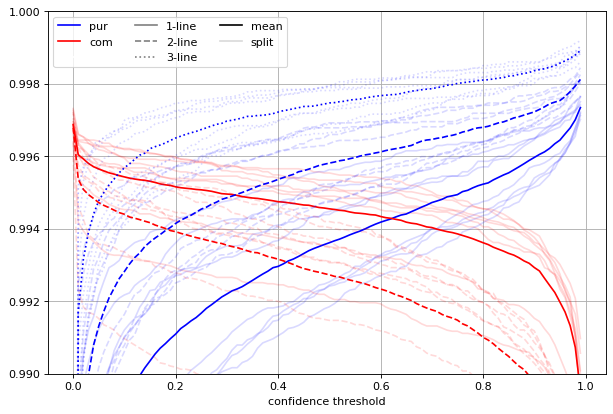

In [98]:
nd_linestyles = {1:'-', 2:'--', 3:':'}
q_colours = {'pur':'b','com':'r'}

plt.figure(figsize=(9,6),dpi=80)

for ndetect in ndetect_vals:
    pur_mean = np.zeros(c_th.shape)
    com_mean = np.zeros(c_th.shape)

    for isplit in ivals:
        pur_mean += results_dict[isplit][ndetect]['pur']
        com_mean += results_dict[isplit][ndetect]['com']
        plt.plot(c_th, results_dict[isplit][ndetect]['pur'],color='b',alpha=0.15,linestyle=nd_linestyles[ndetect])
        plt.plot(c_th, results_dict[isplit][ndetect]['com'],color='r',alpha=0.15,linestyle=nd_linestyles[ndetect])
    
    pur_mean /= len(ivals)
    #pur_rms = np.sqrt(pur_rms)
    com_mean /= len(ivals)
    #com_rms = np.sqrt(com_rms)

    pur_rms_err = np.zeros(c_th.shape)
    com_rms_err = np.zeros(c_th.shape)
    
    for isplit in ivals:
        pur_rms_err += (results_dict[isplit][ndetect]['pur']-pur_mean)**2
        com_rms_err += (results_dict[isplit][ndetect]['com']-com_mean)**2
    
    pur_rms_err /= len(ivals)
    pur_rms_err = np.sqrt(pur_rms_err)
    com_rms_err /= len(ivals)
    com_rms_err = np.sqrt(com_rms_err)    
    
    plt.plot(c_th, pur_mean, color='b',linestyle=nd_linestyles[ndetect])
    plt.plot(c_th, com_mean, color='r',linestyle=nd_linestyles[ndetect])
    
    #plt.fill_between(c_th,pur_rms+pur_rms_err,pur_rms-pur_rms_err,color='b',alpha=0.5)
    #plt.fill_between(c_th,com_rms+com_rms_err,com_rms-com_rms_err,color='r',alpha=0.5)
    
plt.plot([0],c='b',label='pur')
plt.plot([0],c='r',label='com')
plt.plot([0],c='w',label=' ')
plt.plot([0],c='grey',linestyle='-',label='1-line')
plt.plot([0],c='grey',linestyle='--',label='2-line')
plt.plot([0],c='grey',linestyle=':',label='3-line')
plt.plot([0],c='black',label='mean')
plt.plot([0],c='black',alpha=0.15,label='split')
plt.legend(ncol=3)

plt.ylim(0.99,1.0)
plt.xlabel('confidence threshold')
plt.grid()
plt.savefig('pur_com_vs_cth.pdf')
plt.show()

In [82]:
z_line_bal[c_line_bal>c_th_bal]

NameError: name 'c_th_bal' is not defined